# Convergence of Sequences

Pablo Winant

# Tutorial: Convergence

### Solow Model

A representative agent uses capital $k_t$ to produce $y_t$ using the
following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what
remains:

$$i_t = y_t - c_t$$

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount
invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount
factor.

For now, we ignore the objective and assume that the saving rate
$s=\frac{c_t}{y_t}$ is constant over time. **(1-s plutôt ?)**

**Create a `NamedTuple` to hold parameter values $\beta=0.96$,
$\delta=0.1$, $\alpha=0.3$, $\gamma=4$.**

**Write down the formula of function $f$ such that $k_{t+1}$:
$k_{t+1} = f(k_t)$.**

**Define a function `f(k::Float64, p::NamedTuple)::Float64` to represent
$f$ for a given calibration**

$ k_{t+1} = (1-\delta)k_t + s.k_{t}^{\alpha} == f(k_t) \qquad $  (S= (1-s) de l'énoncé...)

$ f'(k) = (1-\delta) + s.α.k^{\alpha-1}$

---

- Julia REPL
    - ] for packages
    - ; for shell
    - ? for help

In [2]:
using Plots, Printf
model = (α=0.3, β=0.96, δ=0.1, γ=4)

#? Notes : 
# model_2 = merge(model, (;α=0.4)) to create new model
# syntax to "unpack" values from named tuple : 
# (;α, β, δ, γ) = model

(α = 0.3, β = 0.96, δ = 0.1, γ = 4)

In [16]:
function f(k::Float64, model; s=0.3)

    (;α, β, δ, γ) = model
    y = k^α
    i = s*y
    K = (1-δ)*k + i

    return K
end

function df(k, model; s=0.3)

    (;α, β, δ, γ) = model
    return (1-δ) + s*α*k^(α-1)
end

# -----------------------------
# Pour visu méthode de Newton :
# -----------------------------

# f(k) - k
f1 = (k, model; s=0.3) -> f(k,model; s=s) - k
# f'(k) - 1
f2 = (k, model; s=0.3) -> df(k,model; s=s) - 1
# f(k) - k / f'(k) - 1
f3 = (k, model; s=0.3) -> f1(k,model; s=s) / f2(k,model;s=s)
# f4 : k - [f(k) - k] / [f'(k) - 1]
f4 = (k, model; s=0.3) -> k - f1(k,model; s=s) / f2(k,model;s=s)

function plotf(func, model, s; title="f", maxy=false, id=false)
    grid = LinRange(0,10,1000)
    res = [func(x,model;s=s) for x in grid]
    #--------
    if maxy
        plt = plot(xlim=(grid[1],grid[end]),ylim=(-50,50))
    else
        plt = plot(xlim=(grid[1],grid[end]),ylim=(minimum(res)*(1-0.1),maximum(res)*(1+0.1)))
    end
    #--------
    if id
        plot!(plt,grid, grid, c=:green, label="identity")
    end
    #--------
    plot!(plt, grid, res, c=:black, label=title)
    plot!(plt,[grid[1],grid[end]], [0,0], linestyle = :dash, c=:gray, label="0")
    #--------
end

plotf (generic function with 1 method)

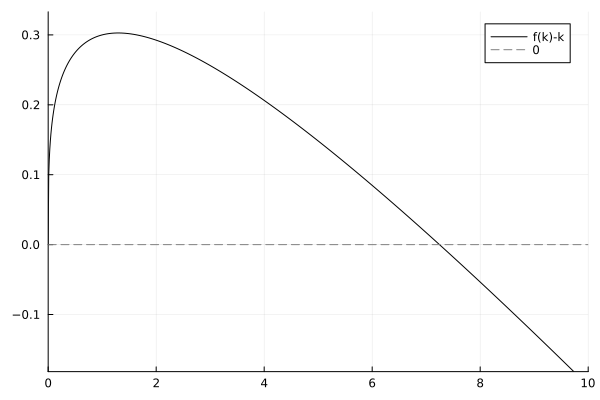

In [17]:
# Plot de f(k) - k
# On peut voir point fixe autour de 7
plotf(f1,model,0.4; title="f(k)-k")

**Write a function
`simulate(k0::Float64, T::Int, p::NamedTuple)::Vector{Float64}` to
compute the simulation over `T` periods starting from initial capital
level `k0`.**

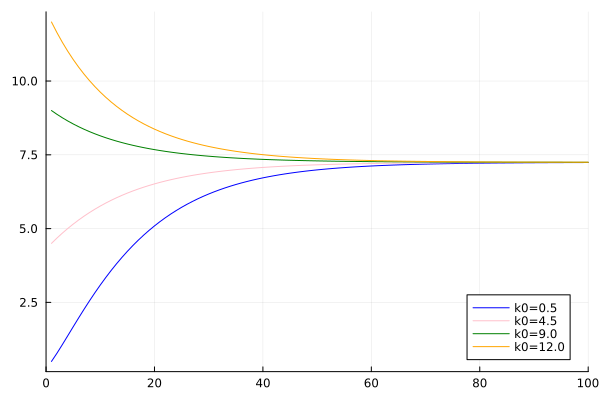

In [5]:
function simulate(k0::Float64, model; s::Float64=0.4, T::Int=100, deb::Bool=false)
    res = [k0]
    succ_errors = []
    
    if deb
        println(">>> NAIVE ITERATIVE METHOD")
        println("----------------------------------------------------------------------------------------------------------------------------")
    end

    # ===========
    for t=1:T
        k = res[end]
        K = f(k, model; s=s)
        push!(res, K)

        if deb
            crit = abs(K)
            cvspeed = abs(K-k)
            push!(succ_errors,cvspeed)

            #? try car pour 1st step (k0) il n'y a pas de succ_errors[end-1], ensuite c'est good pour calculer le ratio
            try
                ratio = succ_errors[end]/succ_errors[end-1]
                @printf "iter : %3.0f | K : %12.9f | Successive errors : %.12f | Success criterion : %9.6f | RATIO : %.12f \n" t k cvspeed crit ratio
            catch
            end
        end
    end
    # ===========

    if deb
        println("----------------------------------------------------------------------------------------------------------------------------")
    end

    return res
end

fig = plot(xlim=(0,100), legend=:bottomright)
plot!(fig, simulate(0.5, model), c=:blue, label="k0=0.5")
plot!(fig, simulate(4.5, model), c=:pink, label="k0=4.5")
plot!(fig, simulate(9.0, model), c=:green, label="k0=9.0")
plot!(fig, simulate(12.0, model), c=:orange, label="k0=12.0")

#* A l'air de converger vers environ k* = 7,2(...)

`Do we get convergence from any initial level of capital?`
 
**With simple method of $k_{t+1} = f(k_t)$ YES eventually after enough iteration.** <br>
**But NOT from anywhere with Newton: problem with the derivate around certain point.**

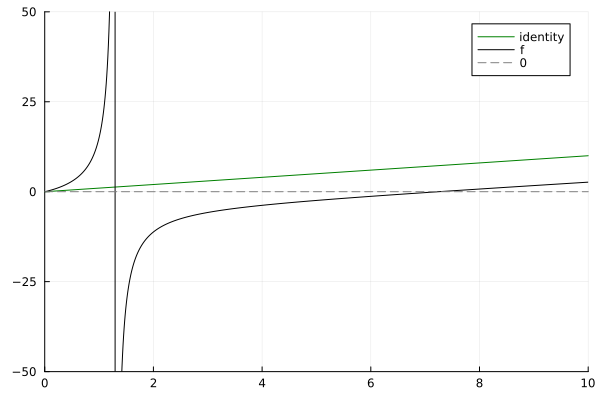

In [6]:
#! Il y a un problème avec méthode de Newton si on initialise k0 < environ 1.4 !
#! Plus on s'approche de ce point plus k_{n+1} -> inf et pour k0<1.4 on a k1<0
# f3 : [f(k) - k] / [f'(k) - 1]
# f4 : identity - f3
#! pb si f4 < 0

# display(plotf(f4,model,0.4,maxy=true))
display(plotf(f3,model,0.4,maxy=true,id=true))

**Taylor expansion**

$f(x) = f(a) + \frac {f'(a)}{1!}(x-a) + \frac{f''(a)}{2!} (x-a)^2+ \cdots + \frac{f^{(n)}(a)}{n!}(x-a)^n + o( (x-a)^n)$

`=> Stability of Fixed point / Steady-satte` 

Autour du point fixe on a :

$x_{n+1} - x = f(x_n) - f(x) = f^{\prime}(x) (x_n-x) + o( (x_n-x) )$

$|x_{n+1} - x| = |f^{\prime}(x)| |x_n-x|$

> Idea : When $|f^{\prime}(x)|<1$, the distance to the target decreases at each iteration and we have convergence. When $|f^{\prime}(x)|>1$ there is local divergence.

<br>

- We can write **successive approximation errors** with iterative approach $x_{n+1}=f(x_n)$:

$|x_t - x_{t-1}| =  | f(x_{t-1}) - f(x_{t-2})| $

$|x_t - x_{t-1}| \sim |f^{\prime}(x_{t-1})| |x_{t-1} - x_{t-2}| $

$\frac{ |x_{t} - x_{t-1}| } { |x_{t-1} - x_{t-2}|} \sim |f^{\prime}(x_{t-1})|$

- **Ratio of successive approximation errors**

$\lambda_t =  \frac{ |x_{t} - x_{t-1}| } { |x_{t-1} - x_{t-2}|} $

> <br> $\lambda_t \rightarrow | f^{\prime}(\overline{x}) |$ <br> <br>
    - if $| f^{\prime}(\overline{x}) |>1$: series is **unstable** and will not converge to $x$ except by chance <br> <br>
    - if $| f^{\prime}(\overline{x}) |<1$: $x$ is a **stable fixed point** <br> <br>
    - if $| f^{\prime}(\overline{x}) |=1$: ??? (look at higher order terms) <br> <br>

<br>


`What would you propose to measure convergence speed? To speed-up convergence using f?`

- **Measure convergence speed using successive errors $\eta_{n} = | k_{n+1} - k_{n} |$**
- **Speed up the convergence using Newton's method applied to $\Phi(x) = f(x) - x$**

> Newton's method applied to $\Phi(x) = f(x) - x$ because we are interested in solving : *$ f(x) = x \Leftrightarrow f(x) - x = 0 \Leftrightarrow \Phi(x) = 0$* *> Newton to find roots*

> $ \textrm{\textbf{Newton}}: \quad k_{n+1} = k_{n} - \frac{f(k_n) - k_n}{f'(k_n)-1}$ <br> <br>
$ \textrm{\textbf{Success criterion}}: \quad \epsilon_{n} = | f(k_n) |$ <br> <br>
$ \textrm{\textbf{Convergence speed}}: \quad \eta_{n} = | k_{n+1} - k_{n} | \quad \textrm{\textit{'Successive erros'}}$ <br> <br>
$ \textrm{\textbf{Ratio of successive errors for kind of convergence}}: \quad \lambda_{n} = \frac{\eta_n}{\eta_{n-1}} \Leftrightarrow |\lambda_n| < 1 ? \quad$ **for stability**


In [7]:
# ===== NEWTON =====
function simulate_newton(k0::Float64, model; s::Float64=0.4, T::Int=100, deb::Bool=false)
    """
    Newton's convergence method
    """
    res = [k0]
    succ_errors = []
    cutoff = 0

    if deb
        println(">>> NEWTON CONVERGENCE")
        println("----------------------------------------------------------------------------------------------------------------------------")
    end
    
    # ===========
    for t=1:T
        k = res[end]
        fk = f(k, model; s=s)
        dfk = df(k, model; s=s)

        if (abs(dfk-1)>10^-16)
            KN = k - (fk-k)/(dfk-1)
            push!(res,KN)
        else
            break
        end


        if deb
            crit = abs(fk)
            cvspeed = abs(KN-k)
            push!(succ_errors,cvspeed)

            try 
                #! dénominateur trop petit pour la division = on arrête d'itérer 
                if (succ_errors[end-1]<10^-16)
                    cutoff = t
                    break
                end
                ratio = succ_errors[end]/succ_errors[end-1]
                @printf "iter : %3.0f | K : %12.9f | Successive errors : %.12f | Success criterion : %9.6f | RATIO : %.12f \n" t k cvspeed crit ratio
            catch
            end
        end
    end
    # ===========
    
    if deb
        println("----------------------------------------------------------------------------------------------------------------------------")
    end

    # Compléter le reste du vecteur avec dernière valeur estimée pour k*
    if cutoff!=0
        res = vcat(res, fill(res[end],T-cutoff))
    end
    return res
end

simulate_newton(2.0, model, deb=true)

>>> NEWTON CONVERGENCE
----------------------------------------------------------------------------------------------------------------------------
iter :   2 | K : 13.191841638 | Successive errors : 5.629484778315 | Success criterion : 12.739922 | Ratio : 0.502998966608 
iter :   3 | K :  7.562356860 | Successive errors : 0.314615960715 | Success criterion :  7.540055 | Ratio : 0.055887167850 
iter :   4 | K :  7.247740899 | Successive errors : 0.001951505960 | Success criterion :  7.247604 | Ratio : 0.006202819323 
iter :   5 | K :  7.245789393 | Successive errors : 0.000000078816 | Success criterion :  7.245789 | Ratio : 0.000040387122 
iter :   6 | K :  7.245789314 | Successive errors : 0.000000000000 | Success criterion :  7.245789 | Ratio : 0.000000000000 
----------------------------------------------------------------------------------------------------------------------------


101-element Vector{Float64}:
  2.0
 13.191841637917717
  7.562356859602338
  7.247740898887396
  7.245789392926962
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  ⋮
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253

`Linear/geometric convergence` : 

$ \lim_{x\rightarrow \infty}\frac{ x_{t+1}-x}{x_t-x} = \mu \in (0,1) $

`Aitken extrapolation` to speed up convergence **in the case of linear convergence** : 

$(Ax)_t = x_{t-1} - \frac{(x_t-x_{t-1})^2}{x_{t+1}-2 x_t + x_{t-1}}$

Will accelerate convergence if : $ \lim_{n\rightarrow \infty}\frac{ (Ax)_n - x^{\star}}{x_n-x^{\star}} = 0 $

**In the case of a fixed point process** $x_{n+1} = f(x_n)$ the Aitken method converges quadratically, this specific application is knwon as <br> `Steffensen's method`

1. Initial guess $x_0$ and compute $x_1 = f(x_0), x_2=f(x_1)$

2. $x_{AK1} = x_{0} - \frac{(x_1-x_{0})^2}{x_{2}-2 x_1 + x_{0}}$

3. Compare $|x_{AK1} - x_2|$ to tolerance level $\epsilon$

4. If $|x_{AK1} - x_2|>\epsilon$ $\rightarrow$ $x_0 = x_{AK1}$ in step1 and compute $x_{AK2}$


In [8]:
# ===== AITKEN EXTRAPOLATION / STEFFENSEN =====
function simulate_aitken(k0::Float64, model; s::Float64=0.4, T::Int=100, deb::Bool=false)
    """
    Aitken extrapolation for fixed point process : Steffensen's convergence method
    """
    res = [k0]
    succ_errors = []
    cutoff = 0

    if deb
        println(">>> AITKEN CONVERGENCE")
        println("----------------------------------------------------------------------------------------------------------------------------")
    end

    # ===========
    for t in 1:(T+1)

        x0 = res[end]
        x1 = f(x0, model; s=s)
        x2 = f(x1, model; s=s)
        den = (x2-2*x1+x0)

        #! dénominateur trop petit pour la division = on arrête d'itérer (tolérance)
        if (abs(den) < 10^-16)
            cutoff = t
            break
        else
            #! AITKEN
            ax = x1 - (x1-x0)^2/den
        end
        push!(res,ax)

        if deb
            crit = abs(f(ax, model; s=s))
            cvspeed = abs(ax-x0)
            push!(succ_errors,cvspeed)

            try
                ratio = succ_errors[end]/succ_errors[end-1]
                @printf "iter : %3.0f | AX : %12.9f | Successive errors : %.12f | Success criterion : %9.6f | RATIO : %.12f \n" t ax cvspeed crit ratio
            catch
            end
        end
    end
    # ===========

    if deb
        println("----------------------------------------------------------------------------------------------------------------------------")
    end

    # Compléter le reste du vecteur avec dernière valeur estimée pour k*
    if cutoff!=0
        res = vcat(res, fill(res[end],T+1-cutoff))
    end
    return res
end

simulate_aitken(2.0, model, deb=true)

>>> AITKEN CONVERGENCE
----------------------------------------------------------------------------------------------------------------------------
iter :   2 | AX :  7.104642546 | Successive errors : 5.059278480116 | Success criterion :  7.114494 | Ratio : 0.497768377695 
iter :   3 | AX :  7.256034630 | Successive errors : 0.151392084338 | Success criterion :  7.255317 | Ratio : 0.029923651156 
iter :   4 | AX :  7.245074007 | Successive errors : 0.010960623294 | Success criterion :  7.245124 | Ratio : 0.072398919283 
iter :   5 | AX :  7.245839395 | Successive errors : 0.000765387832 | Success criterion :  7.245836 | Ratio : 0.069830684918 
iter :   6 | AX :  7.245785809 | Successive errors : 0.000053586214 | Success criterion :  7.245786 | Ratio : 0.070011845022 
iter :   7 | AX :  7.245789560 | Successive errors : 0.000003750991 | Success criterion :  7.245790 | Ratio : 0.069999173784 
iter :   8 | AX :  7.245789297 | Successive errors : 0.000000262570 | Success criterion :  7.245

101-element Vector{Float64}:
  2.0
 12.163921025967909
  7.104642545851661
  7.2560346301892755
  7.245074006895267
  7.245839394727014
  7.245785808512756
  7.24578955950348
  7.2457892969338475
  7.245789315313713
  ⋮
  7.245789314111175
  7.245789314111175
  7.245789314111175
  7.245789314111175
  7.245789314111175
  7.245789314111175
  7.245789314111175
  7.245789314111175
  7.245789314111175

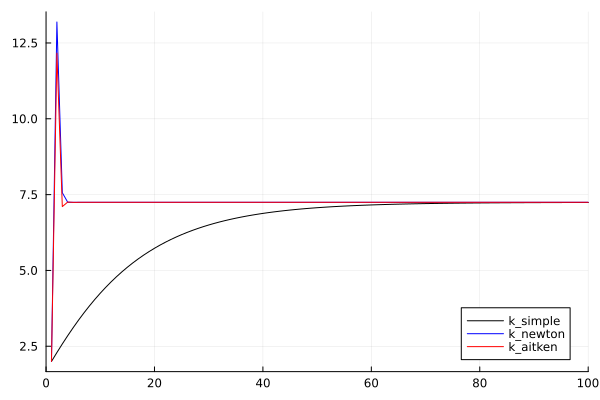

In [9]:
fig = plot(xlim=(0,100), legend=:bottomright)
plot!(fig, simulate(2.0, model), c=:black, label="k_simple")
plot!(fig, simulate_newton(2.0, model), c=:blue, label="k_newton")
plot!(fig, simulate_aitken(2.0, model), c=:red, label="k_aitken")

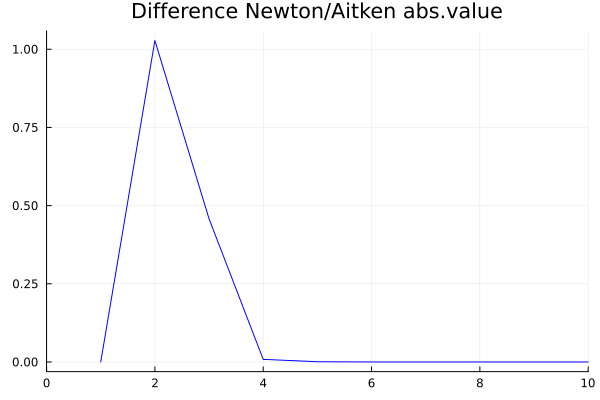

In [10]:
fig = plot(xlim=(0,10), legend=:topright, title="Difference Newton/Aitken abs.value")
plot!(fig, abs.(simulate_newton(2.0, model) - simulate_aitken(2.0, model)), c=:blue, legend=false)